## Import

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
import os

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import core.config as cfg
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri

In [3]:
import helpers.s3 as hs3
import vendors.cme.read as cmer
import vendors.kibot.PartTask269_liquidity_analysis_utils as lau
import vendors.kibot.utils as kut

In [4]:
# import infra.helpers.telegram_notify.telegram_notify as tg
# tgn = tg.TelegramNotify()

In [60]:
sns.set()

In [5]:
print(env.get_system_signature())

pri.config_notebook()

# TODO(gp): Changing level during the notebook execution doesn't work. Fix it.
# dbg.init_logger(verb=logging.DEBUG)
dbg.init_logger(verb=logging.INFO)
# dbg.test_logger()

_LOG = logging.getLogger(__name__)

# Packages
         python: 3.6.7
         joblib: 0.13.2
          numpy: 1.17.2
         pandas: 0.25.1
        pyarrow: 0.14.1
          scipy: 1.3.1
        seaborn: 0.9.0
        sklearn: 0.21.3
    statsmodels: 0.10.1
# Last commits:
  * 0d9ba4d Julia    PartTask269 Modify according to the review                        (   2 hours ago) Fri Oct 11 14:31:50 2019  (HEAD -> PartTask269_PRICE_Liquidity_analysis_as_a_proxy_for_trader_interest, origin/PartTask269_PRICE_Liquidity_analysis_as_a_proxy_for_trader_interest)
  *   5af5db2 Julia    Merge remote-tracking branch 'origin/master' into PartTask269_PRICE_Liquidity_analysis_as_a_proxy_for_trader_interest (   5 hours ago) Fri Oct 11 12:10:08 2019           
  |\  
  * | 74a1ce7 Julia    PartTask269 move files to vendors/kibot                           (   5 hours ago) Fri Oct 11 11:55:20 2019           


# Metadata

In [6]:
df1 = kut.read_metadata1()
df1.head(3)

,Symbol,Link,Description
All_Futures_Contracts_1min.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [7]:
df2 = kut.read_metadata2()
df2.head(3)

,Symbol,Link,Description
All_Futures_Contracts_daily.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [8]:
df3 = kut.read_metadata3()
df3.head(3)

,SymbolBase,Symbol,StartDate,Size(MB),Description,Exchange
1.0,ES,ES,9/30/2009,50610.0,CONTINUOUS E-MINI S&P 500 CONTRACT,Chicago Mercantile Exchange Mini Sized Contrac...
2.0,ES,ESH11,4/6/2010,891.0,E-MINI S&P 500 MARCH 2011,Chicago Mercantile Exchange Mini Sized Contrac...
3.0,ES,ESH12,3/6/2011,1060.0,E-MINI S&P 500 MARCH 2012,Chicago Mercantile Exchange Mini Sized Contrac...


In [9]:
df4 = kut.read_metadata4()
print(df4.head(3))

print(df4["Exchange"].unique())

    SymbolBase Symbol  StartDate  Size(MB)                                 Description                                  Exchange
1.0         JY     JY  9/27/2009     183.0            CONTINUOUS JAPANESE YEN CONTRACT  Chicago Mercantile Exchange (CME GLOBEX)
2.0         TY     TY  9/27/2009     180.0  CONTINUOUS 10 YR US TREASURY NOTE CONTRACT      Chicago Board Of Trade (CBOT GLOBEX)
3.0         FV     FV  9/27/2009     171.0   CONTINUOUS 5 YR US TREASURY NOTE CONTRACT      Chicago Board Of Trade (CBOT GLOBEX)
['Chicago Mercantile Exchange (CME GLOBEX)'
 'Chicago Board Of Trade (CBOT GLOBEX)'
 'Chicago Mercantile Exchange Mini Sized Contracts (CME MINI)'
 'Commodities Exchange Center (COMEX GLOBEX)'
 'New York Mercantile Exchange (NYMEX GLOBEX)'
 'Chicago Board Of Trade Mini Sized Contracts (CBOT MINI)'
 'New York Mercantile Exchange Mini Sized Contracts'
 'CBOE Futures Exchange (CFE)' nan]


# Load product specs

In [10]:
product_specs = cmer.read_product_specs()

Reading s3://default00-bucket/cme/product_slate_export_with_contract_specs_20190905.csv


In [11]:
product_specs.head()

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,Exchange,Volume,Open Interest,product_link,Contract Unit,Price Quotation,Trading Hours,Minimum Price Fluctuation,Product Code,Listed Contracts,Settlement Method,Termination Of Trading,Settlement Procedures,Position Limits,Exchange Rulebook,Block Minimum,Price Limit Or Circuit,All Or None Minimum,Vendor Codes,Settlement Procedures Link,Position Limits Link,Exchange Rulebook Link,Block Minimum Link,Price Limit Or Circuit Link,All Or None Minimum Link,Vendor Codes Link,Delivery Procedure,Last Delivery Date,Grade And Quality,Trade At Marker Or Trade At Settlement Rules,Delivery Period,Minimum Price Fluctuation_0,Grade And Quality Link,Floating Price,Days Or Hours,Trading Hours_0,Delivery Period Link,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
0,ED,GE,NaN,ED,Eurodollar Futures,Interest Rate,Stirs,NaN,NaN,Futures,CME,3104281,13213901,http://www.cmegroup.com/trading/interest-rates...,"$2,500 x Contract IMM Index",Contract IMM Index = 100 minus R R = three-mon...,SUN - FRI: 5:00 p.m. - 4:00 p.m. CT,Nearest expiring contract month: One quarter o...,CME Globex: GECME ClearPort: EDClearing: ED,"Nearest 40 months (i.e., 10 years) in the Marc...",Financially Settled,Second London bank business day before 3rd Wed...,Eurodollar Future Settlement Procedures,CME Position Limits,CME 452,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,http://www.cmegroup.com/rulebook/CME/V/450/452...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,ZF,NaN,25,5-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,1166719,4162661,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,SUN - FRI: 5:00 p.m. - 4:00 p.m.,One-quarter of one thirty-second (1/32) of one...,CME Globex: ZFCME ClearPort: 25Clearing: 25,The first three consecutive contracts in the M...,Deliverable,Last business day of the calendar month. Tradi...,Treasury Settlement Procedures,CBOT Position Limits,CBOT 20,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,https://www.cmegroup.com/rulebook/CBOT/II/20.pdf,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,/clearing/trading-practices/all-or-none.html,http://www.cmegroup.com/tools-information/vend...,Federal Reserve book-entry wire-transfer system.,Third business day following the last trading ...,U.S. Treasury notes with an original term to m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ZN,NaN,21,10-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,2181982,3656744,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p....,Outrights: One-half of one thirty-second (1/32...,CME Globex: ZNCME ClearPort: 21Clearing: 21,"Quarterly contracts (Mar, Jun, Sep, Dec) liste...",Deliverable,Trading terminates on the seventh business day...,Treasury Settlement Procedures,CBOT Position Limits,CBOT Chapter 19,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/

In [12]:
product_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 57 columns):
Clearing                                             1178 non-null object
Globex                                               1170 non-null object
Floor                                                1 non-null object
Clearport                                            1178 non-null object
Product Name                                         1178 non-null object
Product Group                                        1178 non-null object
Sub Group                                            1178 non-null object
Category                                             747 non-null object
Sub Category                                         818 non-null object
Cleared As                                           1178 non-null object
Exchange                                             1178 non-null object
Volume                                               1178 non-null int64
Open Intere

# Explore metadata

In [13]:
df4["Exchange"].value_counts()

Chicago Mercantile Exchange (CME GLOBEX)                       36
Chicago Board Of Trade (CBOT GLOBEX)                           15
Chicago Mercantile Exchange Mini Sized Contracts (CME MINI)    15
New York Mercantile Exchange (NYMEX GLOBEX)                     7
Commodities Exchange Center (COMEX GLOBEX)                      7
Chicago Board Of Trade Mini Sized Contracts (CBOT MINI)         4
New York Mercantile Exchange Mini Sized Contracts               2
CBOE Futures Exchange (CFE)                                     1
Name: Exchange, dtype: int64

In [14]:
df3["Exchange"].value_counts()

Chicago Mercantile Exchange (CME GLOBEX)                       1999
New York Mercantile Exchange (NYMEX GLOBEX)                     974
Chicago Board Of Trade (CBOT GLOBEX)                            971
Commodities Exchange Center (COMEX GLOBEX)                      661
Chicago Mercantile Exchange Mini Sized Contracts (CME MINI)     529
New York Mercantile Exchange Mini Sized Contracts               262
Chicago Board Of Trade Mini Sized Contracts (CBOT MINI)         232
CBOE Futures Exchange (CFE)                                     121
Name: Exchange, dtype: int64

Kibot only has the CME group futures.

In [15]:
product_specs["Globex"].head()

0    GE
1    ZF
2    ZN
3    ZT
4    ES
Name: Globex, dtype: object

In [16]:
# daily_futures_w_ext = os.listdir
#    "/data/kibot/All_Futures_Continuous_Contracts_daily/"
# )

daily_futures_path = os.path.join(
    hs3.get_path(), "kibot/All_Futures_Continuous_Contracts_daily"
)
daily_futures_w_ext = hs3.ls(daily_futures_path)

In [17]:
daily_futures_w_ext[:5]

['AC.csv.gz', 'AD.csv.gz', 'AE.csv.gz', 'AEX.csv.gz', 'AJY.csv.gz']

In [18]:
daily_futures = list(map(lambda x: x[:-7], daily_futures_w_ext))
daily_futures[:5]

['AC', 'AD', 'AE', 'AEX', 'AJY']

In [19]:
len(set(daily_futures)), df3["SymbolBase"].nunique()

(252, 87)

In [20]:
np.setdiff1d(df3["SymbolBase"].dropna().values, daily_futures)

array([], dtype=object)

In [21]:
product_specs["Globex"].nunique()

1170

In [22]:
np.intersect1d(
    product_specs["Globex"].dropna().unique(), df3["SymbolBase"].dropna().values
)

array(['AJY', 'BTC', 'BZ', 'CL', 'EAD', 'ECD', 'EMD', 'ES', 'GC', 'GF',
       'HE', 'HG', 'HO', 'JE', 'LE', 'M6A', 'M6B', 'M6E', 'MCD', 'ME',
       'MGC', 'MJY', 'MSF', 'NG', 'NIY', 'NKD', 'NOK', 'NQ', 'PA', 'PJY',
       'PL', 'QG', 'QI', 'QM', 'QO', 'RB', 'RF', 'RP', 'RTY', 'RY', 'SEK',
       'SI', 'SIL', 'SIR', 'SP', 'TN', 'UB', 'XAB', 'XAE', 'XAF', 'XAI',
       'XAK', 'XAP', 'XAU', 'XAV', 'XAY', 'YM'], dtype=object)

In [23]:
np.intersect1d(
    product_specs["Globex"].dropna().unique(), df3["SymbolBase"].dropna().values
).shape

(57,)

In [24]:
np.intersect1d(
    product_specs["Globex"].dropna().unique(), df2["Symbol"].dropna().values
).shape

(86,)

In [25]:
np.intersect1d(
    product_specs["Globex"].dropna().unique(), df1["Symbol"].dropna().values
).shape

(86,)

In [26]:
product_specs[product_specs["Globex"].isna()]

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,Exchange,Volume,Open Interest,product_link,Contract Unit,Price Quotation,Trading Hours,Minimum Price Fluctuation,Product Code,Listed Contracts,Settlement Method,Termination Of Trading,Settlement Procedures,Position Limits,Exchange Rulebook,Block Minimum,Price Limit Or Circuit,All Or None Minimum,Vendor Codes,Settlement Procedures Link,Position Limits Link,Exchange Rulebook Link,Block Minimum Link,Price Limit Or Circuit Link,All Or None Minimum Link,Vendor Codes Link,Delivery Procedure,Last Delivery Date,Grade And Quality,Trade At Marker Or Trade At Settlement Rules,Delivery Period,Minimum Price Fluctuation_0,Grade And Quality Link,Floating Price,Days Or Hours,Trading Hours_0,Delivery Period Link,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
158,DTR,NaN,NaN,DTR,Dow Jones Industrial Average Total Return Inde...,Equities,US Index,NaN,NaN,Futures,CBOT,0,8950,http://www.cmegroup.com/trading/equity-index/u...,$2 x DJIA Total Return Index,NaN,Clearport: Sunday - Friday 6:00 p.m. - 5:00 p....,5 Index Point = $10.00 BTIC 0.5 Index Points =...,CME ClearPort: DTRClearing: DTRBTIC: DTT,"5 months in the March Quarterly Cycle (Mar, Ju...",Financially Settled,Trading in expiring futures terminates on the ...,NaN,CME Position Limits,CBOT 31,Block Minimum Thresholds,Price Limits,NaN,Quote Vendor Symbols Listing,NaN,http://www.cmegroup.com/rulebook/files/positio...,https://www.cmegroup.com/content/dam/cmegroup/...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/trading/equity-index/p...,NaN,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
512,SUT,NaN,NaN,SUT,S&P 500 Value BTIC Futures,Equities,US Index,NaN,NaN,Futures,CME,0,0,http://www.cmegroup.com/trading/equity-index/u...,$250 x S&P 500/Value Index,NaN,CME Globex: Sunday - Friday 6:00 p.m. - 5:00 p...,Outright: 0.10 Index Points=$25.00 Calendar Sp...,CME Globex: SUCME ClearPort: SUClearing: SUBTI...,"Quarterly contracts (Mar, Jun, Sep, Dec) liste...",Financially Settled,Trading terminates on the business day before ...,Settlement Procedures,CME Position Limits,CME 356,Block Minimum Thresholds,Price Limits,NaN,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,http://www.cmegroup.com/rulebook/CME/IV/350/35...,http://www.cmegroup.com/clearing/trading-pract...,https://www.cmegroup.com/trading/price-limits....,NaN,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
547,R2R,NaN,NaN,R2R,Russell 2000 Total Return Index Futures,Equities,US Index,NaN,NaN,Futures,CME,0,0,http://www.cmegroup.com/trading/equity-index/u...,$10 x Russell 2000 Total Return Index,NaN,Clearport: Sunday - Friday 6:00 p.m. - 5:00 p....,1 Index Point = $10.00 BTIC: 0.10 Index Points...,CME ClearPort: R2RClearing: R2RBTIC: R2T,"5 months in the March Quarterly Cycle (Mar, Ju...",Financially Settled,Trading in expiring futures terminates on the ...,NaN,CME Position Limits,CME 398,Block Minimum Thresholds,Price Limits,NaN,Quote Vendor Symbols Listing,NaN,http://www.cmegroup.com/rulebook/files/positio...,https://www.cmegroup.com/content/dam/cmegroup/...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/trading/equity-index/p...,NaN,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
564,IBB,NaN,NaN,IBB,BTIC on USD-Denominated Ibovespa Index Futures,Equities,International Index,NaN,NaN,Futures,CME,0,0,http://www.cmegroup.com/trading/equity-index/i..

In [27]:
mask = ["GAS" in d or "OIL" in d for d in df4["Description"].astype(str)]
print(sum(mask))
print(df4[mask].drop(["SymbolBase", "Size(MB)"], axis=1))

7
     Symbol  StartDate                                   Description                                           Exchange
10.0     CL  9/27/2009                 CONTINUOUS CRUDE OIL CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
20.0     NG  9/27/2009               CONTINUOUS NATURAL GAS CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
24.0     QM  9/27/2009          CONTINUOUS E-MINI CRUDE OIL CONTRACT  New York Mercantile Exchange Mini Sized Contracts
29.0     RB  9/27/2009             CONTINUOUS RBOB GASOLINE CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
35.0     BO  9/27/2009               CONTINUOUS SOYBEAN OIL CONTRACT               Chicago Board Of Trade (CBOT GLOBEX)
43.0     BZ  9/28/2009  CONTINUOUS BRENT CRUDE OIL LAST DAY CONTRACT        New York Mercantile Exchange (NYMEX GLOBEX)
49.0     QG  9/27/2009        CONTINUOUS E-MINI NATURAL GAS CONTRACT  New York Mercantile Exchange Mini Sized Contracts


In [28]:
df4[mask]["Symbol"].values

array(['CL', 'NG', 'QM', 'RB', 'BO', 'BZ', 'QG'], dtype=object)

# Read config

In [29]:
config = cfg.Config.from_env()

if config is None:
    config = cfg.Config()
    config_tmp = config.add_subconfig("read_data")
    # config_tmp["nrows"] = 100000
    config_tmp["nrows"] = None
    #
    config["zscore_com"] = 28

print(config)

read_data:
  nrows: None
zscore_com: 28


# Prices

## Read daily prices

In [30]:
all_symbols = daily_futures.copy()

In [31]:
symbols = df4[mask]["Symbol"].values
symbols

array(['CL', 'NG', 'QM', 'RB', 'BO', 'BZ', 'QG'], dtype=object)

In [32]:
file_name = os.path.join(daily_futures_path, "%s.csv.gz")
daily_price_dict_df = kut.read_multiple_symbol_data(
    symbols, file_name, nrows=config["read_data"]["nrows"]
)

daily_price_dict_df["CL"].tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/CL.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/NG.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/QM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/RB.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/BO.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/BZ.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/QG.csv.gz', None) kwargs={}


,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


# Top futures by volume

## Sum volume

In [33]:
daily_vol = lau.get_sum_daily_prices(daily_price_dict_df, price_col=lau.KIBOT_VOL)
daily_vol.sort_values("sum_vol", ascending=False)

,sum_vol
symbol,
CL,1406297147
NG,462417257
BO,171761967
RB,145838317
QM,56211899
BZ,38764685
QG,9643541


## Mean volume

In [34]:
mean_vol = lau.get_mean_daily_prices(daily_price_dict_df, price_col=lau.KIBOT_VOL)
mean_vol.sort_values("mean_vol", ascending=False)

,mean_vol
symbol,
CL,246892.055302
NG,78415.678650
RB,42382.539087
BO,28872.409985
QM,15245.972064
BZ,12831.739490
QG,2616.971777


# Study volume

In [35]:
symbol = "CL"

In [39]:
%%time
vs = lau.PricesStudy(lau.read_kibot_prices, symbol, lau.KIBOT_VOL, n_rows=None)

CPU times: user 51 µs, sys: 0 ns, total: 51 µs
Wall time: 55.1 µs


In [40]:
# tgn.notify('Kibot prices are loaded.')

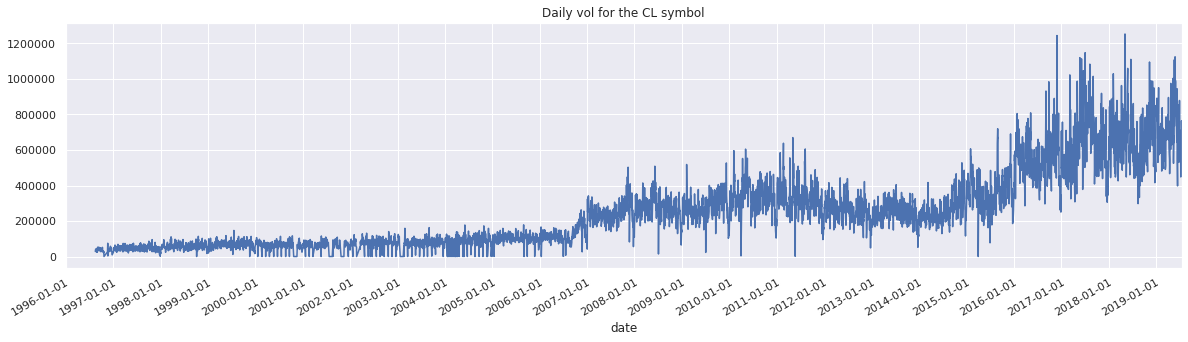

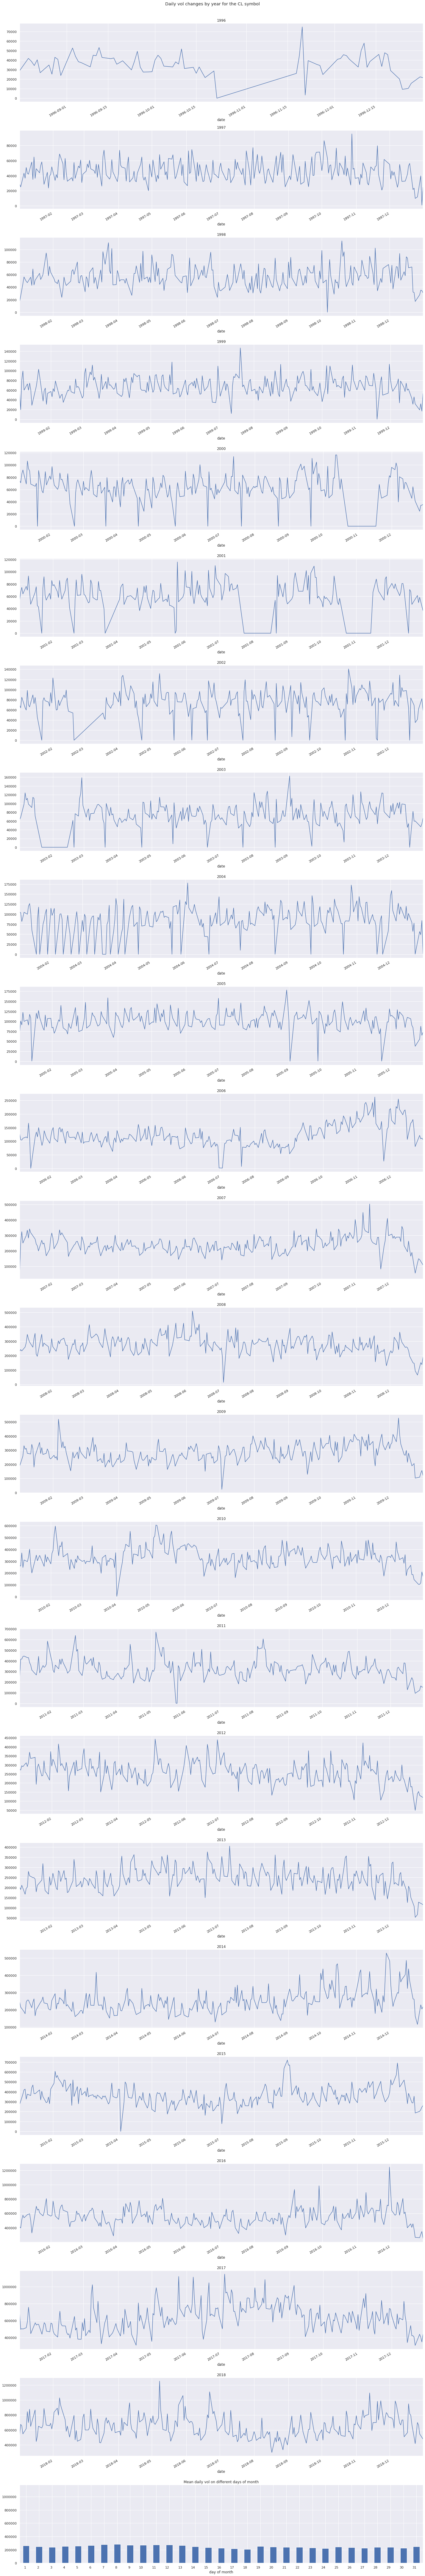

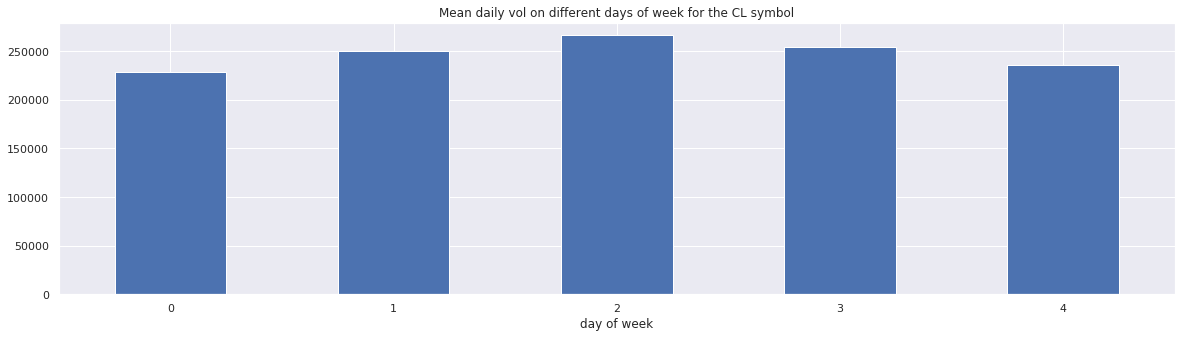

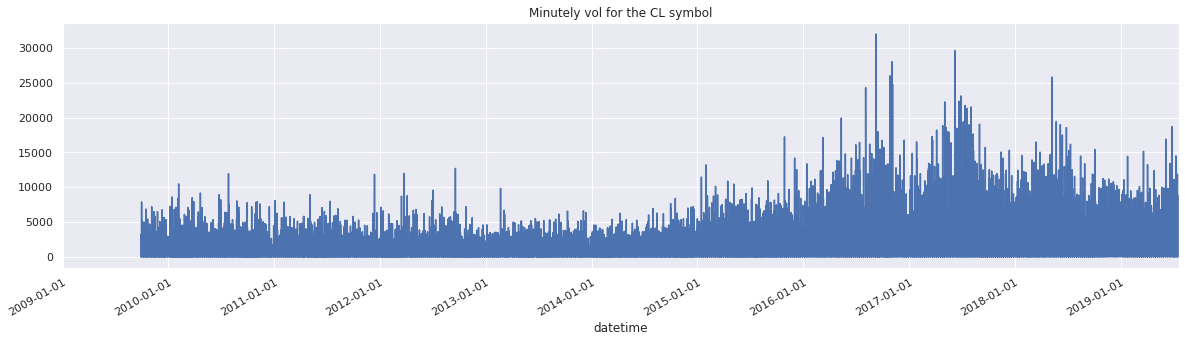

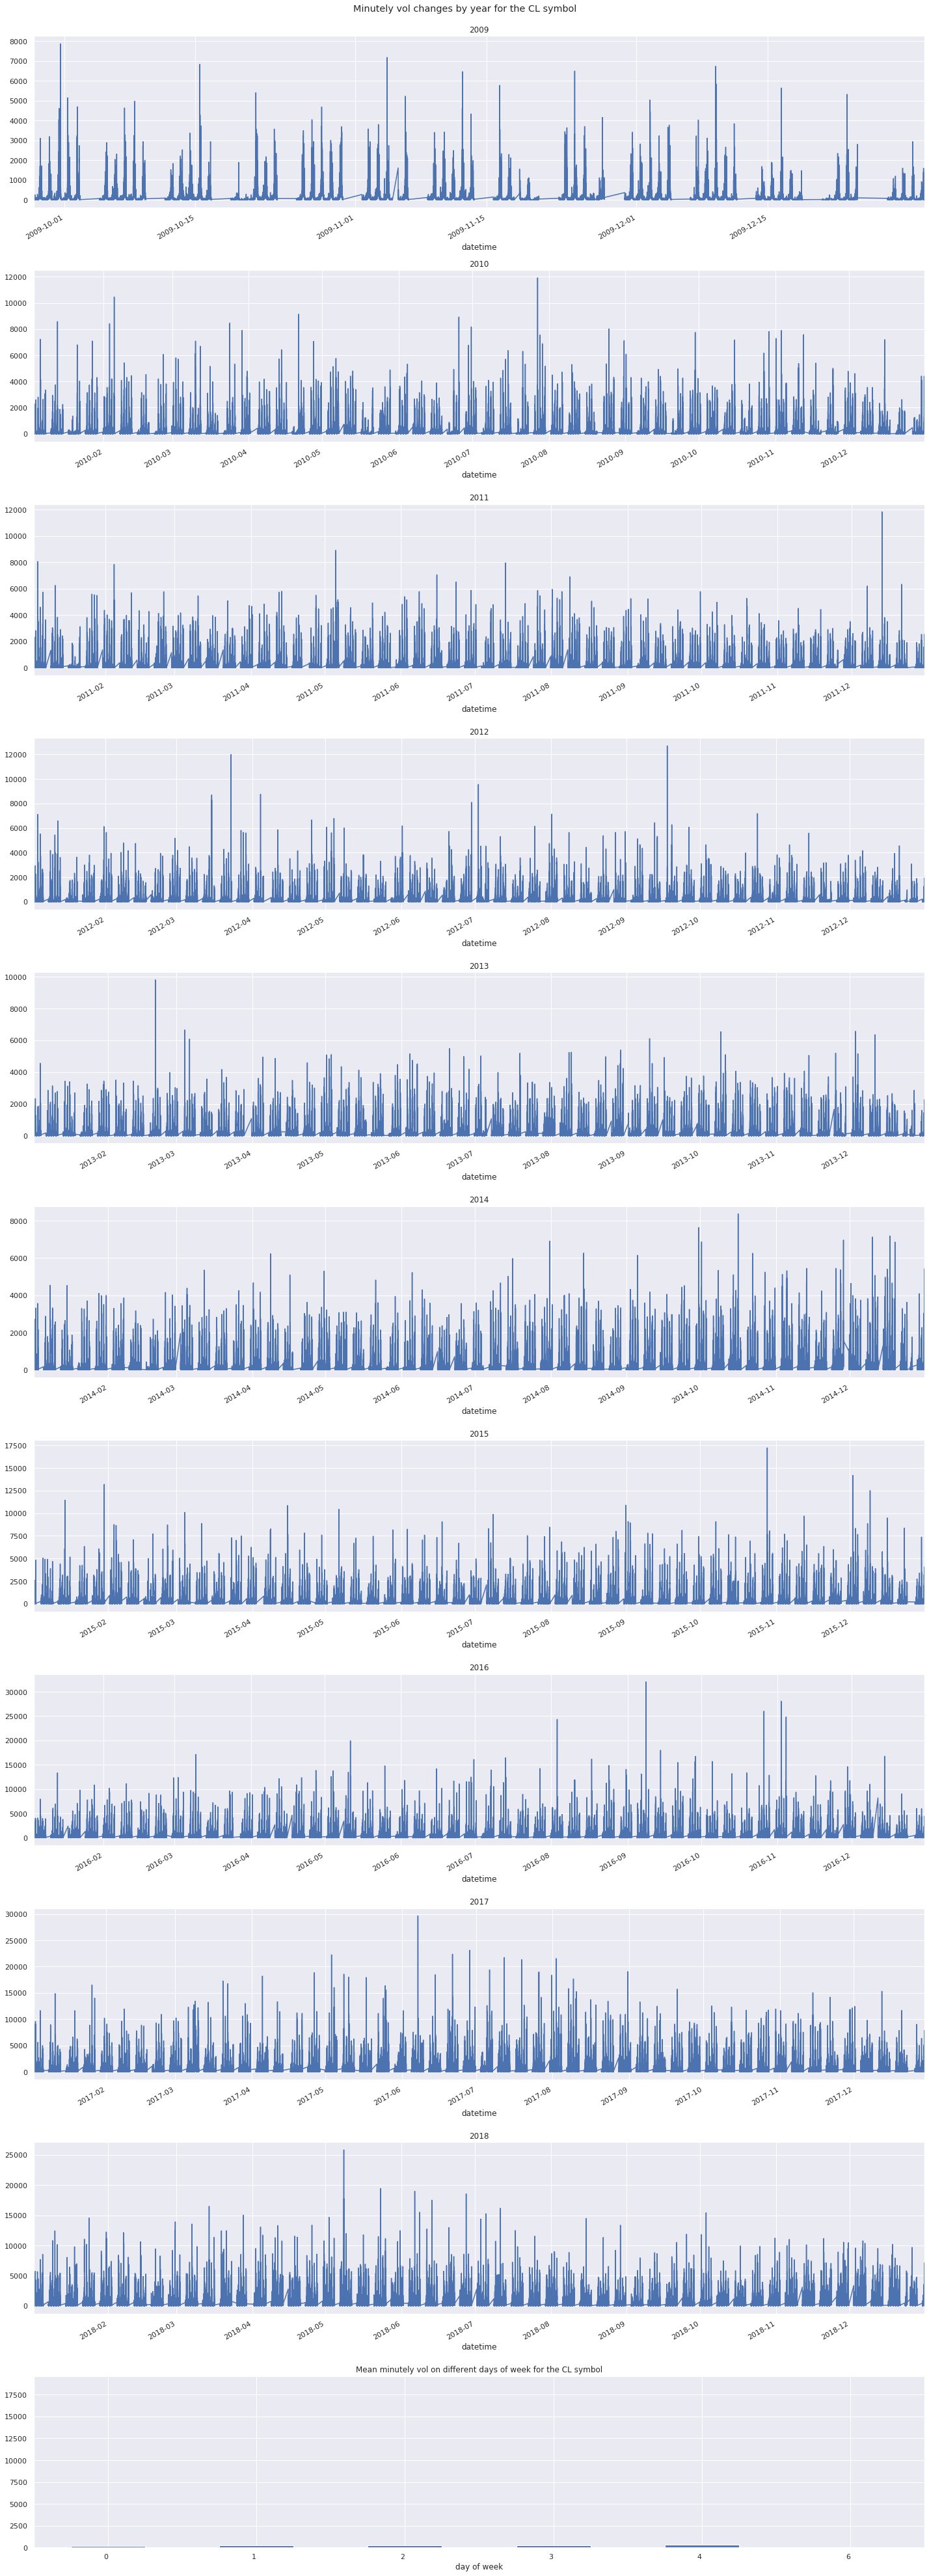

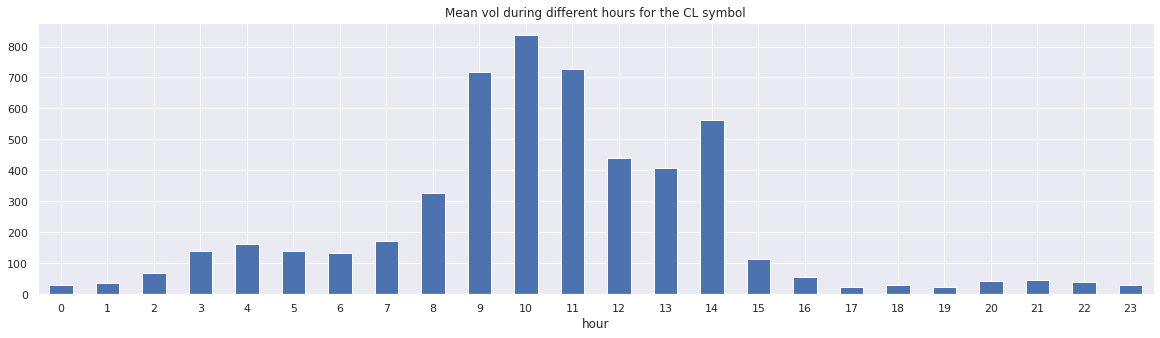

In [61]:
vs.execute()

In [42]:
# tgn.notify('Prices study is complete')

## How is the volume related to the open interest from the metadata?

In [43]:
product_specs.head()

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,Exchange,Volume,Open Interest,product_link,Contract Unit,Price Quotation,Trading Hours,Minimum Price Fluctuation,Product Code,Listed Contracts,Settlement Method,Termination Of Trading,Settlement Procedures,Position Limits,Exchange Rulebook,Block Minimum,Price Limit Or Circuit,All Or None Minimum,Vendor Codes,Settlement Procedures Link,Position Limits Link,Exchange Rulebook Link,Block Minimum Link,Price Limit Or Circuit Link,All Or None Minimum Link,Vendor Codes Link,Delivery Procedure,Last Delivery Date,Grade And Quality,Trade At Marker Or Trade At Settlement Rules,Delivery Period,Minimum Price Fluctuation_0,Grade And Quality Link,Floating Price,Days Or Hours,Trading Hours_0,Delivery Period Link,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
0,ED,GE,NaN,ED,Eurodollar Futures,Interest Rate,Stirs,NaN,NaN,Futures,CME,3104281,13213901,http://www.cmegroup.com/trading/interest-rates...,"$2,500 x Contract IMM Index",Contract IMM Index = 100 minus R R = three-mon...,SUN - FRI: 5:00 p.m. - 4:00 p.m. CT,Nearest expiring contract month: One quarter o...,CME Globex: GECME ClearPort: EDClearing: ED,"Nearest 40 months (i.e., 10 years) in the Marc...",Financially Settled,Second London bank business day before 3rd Wed...,Eurodollar Future Settlement Procedures,CME Position Limits,CME 452,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,http://www.cmegroup.com/rulebook/CME/V/450/452...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,ZF,NaN,25,5-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,1166719,4162661,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,SUN - FRI: 5:00 p.m. - 4:00 p.m.,One-quarter of one thirty-second (1/32) of one...,CME Globex: ZFCME ClearPort: 25Clearing: 25,The first three consecutive contracts in the M...,Deliverable,Last business day of the calendar month. Tradi...,Treasury Settlement Procedures,CBOT Position Limits,CBOT 20,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,https://www.cmegroup.com/rulebook/CBOT/II/20.pdf,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,/clearing/trading-practices/all-or-none.html,http://www.cmegroup.com/tools-information/vend...,Federal Reserve book-entry wire-transfer system.,Third business day following the last trading ...,U.S. Treasury notes with an original term to m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ZN,NaN,21,10-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,2181982,3656744,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p....,Outrights: One-half of one thirty-second (1/32...,CME Globex: ZNCME ClearPort: 21Clearing: 21,"Quarterly contracts (Mar, Jun, Sep, Dec) liste...",Deliverable,Trading terminates on the seventh business day...,Treasury Settlement Procedures,CBOT Position Limits,CBOT Chapter 19,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/

In [44]:
product_specs[product_specs["Globex"] == symbol]["Open Interest"].values

array([2082415])

In [45]:
product_specs[product_specs["Globex"] == symbol]["Volume"].values

array([1484335])

In [46]:
vs.daily_prices[lau.KIBOT_VOL].max()

1253566

In [47]:
vs.minutely_prices[lau.KIBOT_VOL].max()

32030

# CME mapping

## Groups overview

In [48]:
pc = lau.ProductSpecs()

Reading s3://default00-bucket/cme/product_slate_export_with_contract_specs_20190905.csv


In [49]:
pc.product_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 57 columns):
Clearing                                             1178 non-null object
Globex                                               1170 non-null object
Floor                                                1 non-null object
Clearport                                            1178 non-null object
Product Name                                         1178 non-null object
Product Group                                        1178 non-null object
Sub Group                                            1178 non-null object
Category                                             747 non-null object
Sub Category                                         818 non-null object
Cleared As                                           1178 non-null object
Exchange                                             1178 non-null object
Volume                                               1178 non-null int64
Open Intere

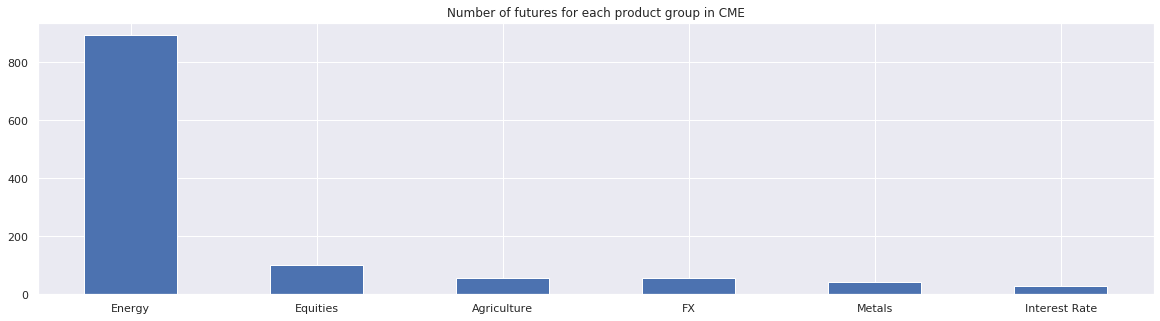

In [62]:
pc.product_specs["Product Group"].value_counts().plot(kind="bar", rot=0)
plt.title("Number of futures for each product group in CME")
plt.show()

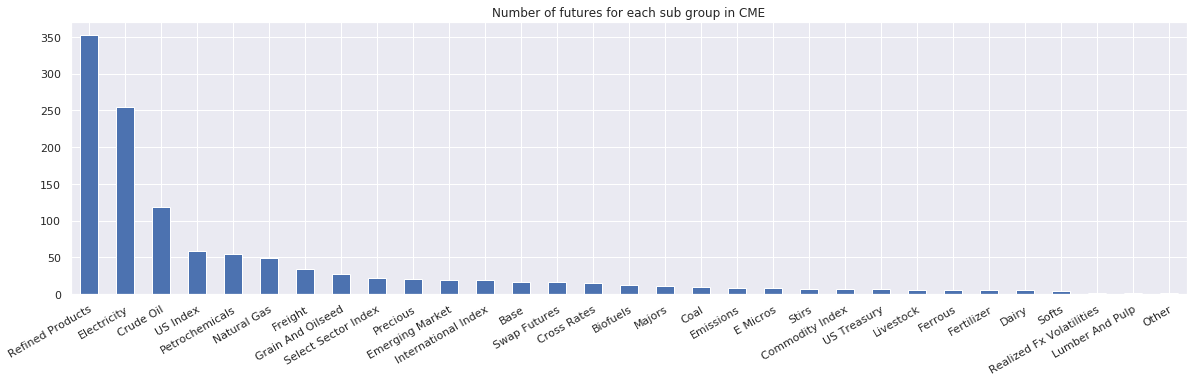

In [63]:
pc.product_specs["Sub Group"].value_counts().plot(kind="bar")
plt.xticks(ha="right", rotation=30, rotation_mode="anchor")
plt.title("Number of futures for each sub group in CME")
plt.show()

In [52]:
pc.product_specs["Category"].astype(str).value_counts()

nan               431
European          179
North American    129
Asian              93
PJM                92
Wet                34
ERCOT              33
NGL                32
ISO-NE             31
MISO               28
NYISO              28
Western Power      24
Canadian           14
Arb                13
LPG                 9
Olefin              5
Resin               3
Name: Category, dtype: int64

In [53]:
pc.product_specs["Sub Category"].astype(str).value_counts()

nan                 360
Outrights           264
Spreads             157
Crack Spreads        66
Monthly Peak         63
Daily Peak           61
Monthly Off-Peak     61
Daily Off-Peak       58
Financial            45
Basis                22
Physical             11
Flats                 7
RGGI                  1
EU ETS                1
Index                 1
Name: Sub Category, dtype: int64

## By symbol

In [54]:
pc.get_metadata_symbol(symbol)

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,Exchange,Volume,Open Interest,product_link,Contract Unit,Price Quotation,Trading Hours,Minimum Price Fluctuation,Product Code,Listed Contracts,Settlement Method,Termination Of Trading,Settlement Procedures,Position Limits,Exchange Rulebook,Block Minimum,Price Limit Or Circuit,All Or None Minimum,Vendor Codes,Settlement Procedures Link,Position Limits Link,Exchange Rulebook Link,Block Minimum Link,Price Limit Or Circuit Link,All Or None Minimum Link,Vendor Codes Link,Delivery Procedure,Last Delivery Date,Grade And Quality,Trade At Marker Or Trade At Settlement Rules,Delivery Period,Minimum Price Fluctuation_0,Grade And Quality Link,Floating Price,Days Or Hours,Trading Hours_0,Delivery Period Link,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
6,CL,CL,NaN,CL,Crude Oil Futures,Energy,Crude Oil,NaN,Outrights,Futures,NYMEX,1484335,2082415,http://www.cmegroup.com/trading/energy/crude-o...,"1,000 barrels",U.S. dollars and cents per barrel,Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p....,0.01 per barrel = $10.00,CME Globex: CLCME ClearPort: CLClearing: CLTAS...,Monthly contracts listed for the current year ...,Deliverable,Trading terminates 3 business day prior to the...,Crude Oil Futures Settlement Procedures,NYMEX Position Limits,NYMEX 200,Block Minimum Thresholds,Price Limits,NaN,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,http://www.cmegroup.com/rulebook/NYMEX/2/200.pdf,http://www.cmegroup.com/clearing/trading-pract...,https://www.cmegroup.com/trading/price-limits....,NaN,http://www.cmegroup.com/tools-information/vend...,"Delivery shall be made free-on-board (""F.O.B.""...",NaN,Please see rulebook chapter 200,Trading at settlement is available for spot (e...,(A) Delivery shall take place no earlier than ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
pc.get_product_group(symbol)

'Energy'

In [56]:
pc.get_trading_hours(symbol)

'Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p.m. - 4:00 p.m. CT) with a 60-minute break each day beginning at 5:00 p.m. (4:00 p.m. CT)'

## For product group

In [57]:
energy_symbols = pc.get_symbols_product_group("Energy")
energy_symbols[:4]

array(['CL', 'NG', 'NN', 'N9L'], dtype=object)

In [58]:
np.intersect1d(energy_symbols, daily_futures)

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [59]:
np.intersect1d(energy_symbols, daily_futures).shape

(23,)